In [235]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import time
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# from sklearn.neural_network import MLPClassifier
import tensorflow as tf

This notebook explores multiple randomized optimization algorithms in 2 experiments \n\
    - 1) Tuning weights on a neural net to predict college footbal outcomes \n\
    - 2) Against a set of 3 well known optimization problems from literature

Tune Neural Net Weights in Context of College Football Problem

In [236]:
# get data
cfb15_21_imp = pd.read_csv('../Data/cfb15_21_imp.csv')
cfb15_21_imp = cfb15_21_imp.drop('Unnamed: 0', axis=1)

In [237]:
df = cfb15_21_imp
df.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA,home_team_cover_spread
0,400603840,2015,1,True,South Carolina,SEC,17,1646,North Carolina,ACC,...,10.0,1.115637,0.461538,0.142857,7.968428,1.130578,0.426667,0.170213,9.157397,1
1,400763593,2015,1,False,UCF,American Athletic,14,1626,Florida International,Conference USA,...,12.0,1.397643,0.362319,0.233333,15.894630,1.365478,0.406250,0.466667,4.270422,0
2,400763399,2015,1,False,Central Michigan,Mid-American,13,1417,Oklahoma State,Big 12,...,12.0,1.234668,0.426471,0.181818,18.608247,1.022896,0.416667,0.333333,8.286312,1
3,400603839,2015,1,False,Vanderbilt,SEC,12,1365,Western Kentucky,Conference USA,...,13.0,1.001898,0.396226,0.380952,4.754122,1.041876,0.397436,0.292683,-3.685131,0
4,400756883,2015,1,False,Utah,Pac-12,24,1603,Michigan,Big Ten,...,11.0,1.163096,0.452055,0.241379,-1.184796,1.085531,0.394366,0.250000,7.254696,1


Preprocess data to get into NN format

In [238]:
excluded = ['id','week','home_team','away_team','margin', 'home_points', 'away_points', 'home_team_cover_spread']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

In [239]:
scaler = MinMaxScaler()
norm = df[cont_features]
norm_train = norm.query("year != 2021")
norm_test = norm.query("year == 2021")
norm_train = norm_train.drop('year',axis=1)
norm_test = norm_test.drop('year', axis=1)
normed_train = scaler.fit_transform(norm_train)
normed_test = scaler.transform(norm_test)
print(normed_train.shape, '\n', normed_test.shape)
print(norm_test.columns)

(4027, 12) 
 (730, 12)
Index(['home_elo', 'away_elo', 'spread', 'h_drives', 'h_d_explosiveness',
       'h_d_successrate', 'h_d_stuffrate', 'h_d_totalPPA', 'h_o_explosiveness',
       'h_o_successrate', 'h_o_stuffrate', 'h_o_totalPPA'],
      dtype='object')


In [240]:
cont_test = pd.DataFrame(normed_test, columns=norm_test.columns)
cont_train = pd.DataFrame(normed_train, columns=norm_train.columns)

In [241]:
conts = pd.concat([cont_train,cont_test],axis=0)
conts

,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
0,0.582134,0.461081,0.483721,0.3125,0.267919,0.426421,0.253968,0.453420,0.246537,0.508663,0.283688,0.429014
1,0.570144,0.368390,0.358140,0.4375,0.388337,0.320731,0.414815,0.548258,0.336639,0.476062,0.777778,0.375059
2,0.444844,0.514557,0.706977,0.4375,0.318746,0.389066,0.323232,0.580727,0.205233,0.492695,0.555556,0.419397
3,0.413669,0.487225,0.353488,0.5000,0.219352,0.356850,0.677249,0.414961,0.212513,0.461988,0.487805,0.287224
4,0.556355,0.506239,0.488372,0.3750,0.288185,0.416319,0.429119,0.343901,0.229258,0.457086,0.416667,0.408007
...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.898082,0.884730,0.576744,0.5000,0.256433,0.453735,0.263374,0.382001,0.386473,0.580137,0.384615,0.619690
726,0.654676,0.764706,0.627907,0.4375,0.198408,0.456522,0.213333,0.451703,0.265561,0.237973,0.161290,0.254696
727,0.637290,0.618538,0.548837,0.6875,0.302220,0.423007,0.592593,0.432506,0.285225,0.428511,0.294118,0.291695
728,0.494005,0.473559,0.474419,0.5625,0.323320,0.369064,0.174863,0.492551,0.171918,0.506460,0.333333,0.439154


In [242]:
onehots = df[cat_features]
onehots.columns

Index(['home_conference', 'away_conference', 'neutral_site'], dtype='object')

In [243]:
oh = OneHotEncoder(sparse=False)
onehots = df[cat_features]
con = pd.DataFrame(oh.fit_transform(df[['home_conference']]))
con.columns = oh.get_feature_names(['home_conference'])
con

C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,home_conference_FBS Independents,home_conference_Mid-American,home_conference_Mountain West,home_conference_Pac-12,home_conference_SEC,home_conference_Sun Belt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [244]:
acon = pd.DataFrame(oh.fit_transform(df[['away_conference']]))
acon.columns = oh.get_feature_names(['away_conference'])
acon

C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,away_conference_ACC,away_conference_American Athletic,away_conference_Big 12,away_conference_Big Ten,away_conference_Conference USA,away_conference_FBS Independents,away_conference_Mid-American,away_conference_Mountain West,away_conference_Pac-12,away_conference_SEC,away_conference_Sun Belt
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [245]:
neut = pd.DataFrame(oh.fit_transform(df[['neutral_site']])).reset_index(drop=True)
neut.columns = oh.get_feature_names(['neutral_site'])
neut

C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,neutral_site_False,neutral_site_True
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
4752,0.0,1.0
4753,0.0,1.0
4754,0.0,1.0
4755,1.0,0.0


In [246]:
leftovers = df[excluded]
leftovers['year'] = df['year']
leftovers = leftovers.reset_index( drop=True)
leftovers

C:\Users\magamp\AppData\Local\Temp\ipykernel_6080\214285720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leftovers['year'] = df['year']


,id,week,home_team,away_team,margin,home_points,away_points,home_team_cover_spread,year
0,400603840,1,South Carolina,North Carolina,-4,17,13,1,2015
1,400763593,1,UCF,Florida International,1,14,15,0,2015
2,400763399,1,Central Michigan,Oklahoma State,11,13,24,1,2015
3,400603839,1,Vanderbilt,Western Kentucky,2,12,14,0,2015
4,400756883,1,Utah,Michigan,-7,24,17,1,2015
...,...,...,...,...,...,...,...,...,...
4752,401282154,14,Alabama,Georgia,-17,41,24,1,2021
4753,401331447,14,Iowa,Michigan,39,3,42,0,2021
4754,401331163,14,Wake Forest,Pittsburgh,24,21,45,0,2021
4755,401387250,14,California,USC,-10,24,14,1,2021


In [247]:
df2 = pd.concat([ leftovers, con, acon, neut,conts.reset_index()], axis=1)
df2 = df2.drop(['id','week','home_team','away_team','margin', 'home_points', 'away_points'],axis=1)
df2

,home_team_cover_spread,year,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,home_conference_FBS Independents,home_conference_Mid-American,home_conference_Mountain West,...,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
0,1,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.483721,0.3125,0.267919,0.426421,0.253968,0.453420,0.246537,0.508663,0.283688,0.429014
1,0,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.358140,0.4375,0.388337,0.320731,0.414815,0.548258,0.336639,0.476062,0.777778,0.375059
2,1,2015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.706977,0.4375,0.318746,0.389066,0.323232,0.580727,0.205233,0.492695,0.555556,0.419397
3,0,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.353488,0.5000,0.219352,0.356850,0.677249,0.414961,0.212513,0.461988,0.487805,0.287224
4,1,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.488372,0.3750,0.288185,0.416319,0.429119,0.343901,0.229258,0.457086,0.416667,0.408007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.576744,0.5000,0.256433,0.453735,0.263374,0.382001,0.386473,0.580137,0.384615,0.619690
4753,0,2021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.627907,0.4375,0.198408,0.456522,0.213333,0.451703,0.265561,0.237973,0.161290,0.254696
4754,0,2021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.548837,0.6875,0.302220,0.423007,0.592593,0.432506,0.285225,0.428511,0.294118,0.291695
4755,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.474419,0.5625,0.323320,0.369064,0.174863,0.492551,0.171918,0.506460,0.333333,0.439154


In [248]:
test_df = df2.query("year == 2021")
train_df = df2.query("year != 2021")
test_df.head()

,home_team_cover_spread,year,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,home_conference_FBS Independents,home_conference_Mid-American,home_conference_Mountain West,...,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
4027,1,2021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.576744,0.4375,0.404618,0.384874,0.313725,0.630643,0.210366,0.542346,0.333333,0.373932
4028,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.260465,0.5625,0.272591,0.109408,0.380952,0.068636,0.265665,0.615390,0.350877,0.575121
4029,1,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.353488,0.5625,0.250465,0.294653,0.654971,0.315272,0.352633,0.490648,0.277778,0.489781
4030,0,2021,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.604651,0.4375,0.392344,0.379948,0.115942,0.617574,0.288884,0.221099,0.245098,0.174284
4031,0,2021,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.455814,0.5000,0.353758,0.311706,0.888889,0.456927,0.313702,0.578795,0.144928,0.537773


In [249]:
trainx = train_df.drop(['home_team_cover_spread', 'year'], axis=1)
testx = test_df.drop(['home_team_cover_spread', 'year'], axis=1)

In [250]:
trainx = trainx.drop('index', axis=1)

In [251]:
testx = testx.drop('index', axis=1)

In [252]:
trainy = train_df[["home_team_cover_spread"]]
testy = test_df[["home_team_cover_spread"]]

Define function for training a nn with different mlrose randomized optimization algorithms

In [253]:
def nn_random_opt(algorithm, train_x, train_y, test_x, test_y, activation, accuracies, times, max_iters, max_attempts = 5, early_stopping = False, mutation_prob = 0.1, hidden_nodes = [6,6], pop_size = 200, summarize = True):
    
    model = mlrose.NeuralNetwork(hidden_nodes=hidden_nodes, activation=activation, algorithm=algorithm, max_iters=max_iters, bias = True, is_classifier= True, learning_rate= 0.001, clip_max=5, max_attempts=max_attempts, random_state=3, curve=True, early_stopping=early_stopping, mutation_prob=mutation_prob, pop_size=pop_size)
    
    # Time fit of model
    st =time.time()
    model.fit(train_x, train_y)
    end = time.time()
    elapsed = end -st
    
    #Predict labels
    y_train_pred = model.predict(train_x)
    y_test_pred = model.predict(test_x)
    test_acc = accuracy_score(test_y, y_test_pred)
    
    accuracies.append(test_acc)
    times.append(elapsed)
    
    if summarize:
        print(classification_report(test_y, y_test_pred))
        print(confusion_matrix(test_y, y_test_pred))
        print("{0} test accuracy: {1}".format(algorithm,test_acc))
        print("{0} time elapsed: {1}".format(algorithm,elapsed))
    
        
    return model
    

Define a function to measure performance and training time of the NN for a given RO algorithm and iteration range

In [254]:
def measure_nn(times, accuracies, iters_range, algo, early_stopping=False, mutation_prob=0.1):
    nn_model = None
    for i in iters_range:
        nn_model = nn_random_opt(algorithm =algo , train_x = trainx, train_y=trainy, test_x=testx, test_y=testy, activation = 'tanh', accuracies=accuracies, times = times, max_iters= i, summarize=False)

    plt.plot(iters_range,times,'*-',color = 'red')
    plt.title("Neural Net Training Time over {0}".format(algo))
    plt.xlabel("Number of iterations")
    plt.ylabel("Time")
    plt.show()

    plt.plot(iters_range,accuracies,'*-',color = 'red')
    plt.title("Neural Net Test Accuracy over {0}".format(algo))
    plt.xlabel("Number of iterations")
    plt.ylabel("Highest Score")
    plt.show()
    return nn_model

Define function to loop over the value of max iterations and output plot of accuracy performance and time taken to train

Train / Optimize NNs with mlrose using various Ranomized Optimization algorithm techniques

Random Hill Climb

In [255]:
hc_times = []
hc_acc = []
nnhc = nn_random_opt(algorithm = 'random_hill_climb', train_x = trainx, train_y=trainy, test_x=testx, test_y=testy, activation = 'relu', accuracies=hc_acc, times = hc_times, max_iters=100, summarize=True)

              precision    recall  f1-score   support

           0       0.51      0.90      0.65       357
           1       0.63      0.16      0.26       373

    accuracy                           0.52       730
   macro avg       0.57      0.53      0.45       730
weighted avg       0.57      0.52      0.45       730

[[322  35]
 [313  60]]
random_hill_climb test accuracy: 0.5232876712328767
random_hill_climb time elapsed: 0.48133015632629395


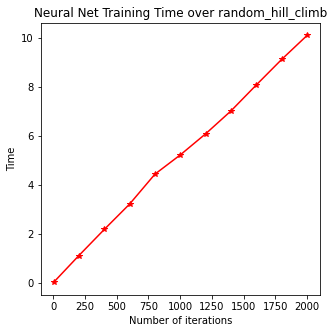

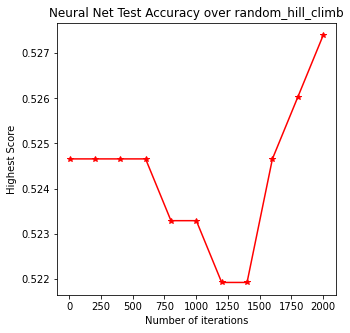

NeuralNetwork(clip_max=5, hidden_nodes=[6, 6], learning_rate=0.001,
              max_iters=2001)

In [256]:
hc_times = []
hc_acc = []
iters_range = range(1, 2200, 200)
measure_nn(hc_times, hc_acc, iters_range, "random_hill_climb")

In [257]:
sa_times = []
sa_acc = []
nnsa = nn_random_opt(algorithm = 'simulated_annealing', train_x = trainx, train_y=trainy, test_x=testx, test_y=testy, activation = 'tanh', accuracies=hc_acc, times = hc_times, max_iters=100, summarize=True)

              precision    recall  f1-score   support

           0       0.51      0.75      0.61       357
           1       0.56      0.31      0.40       373

    accuracy                           0.52       730
   macro avg       0.54      0.53      0.50       730
weighted avg       0.54      0.52      0.50       730

[[269  88]
 [259 114]]
simulated_annealing test accuracy: 0.5246575342465754
simulated_annealing time elapsed: 0.6913082599639893


Simulated Annealing

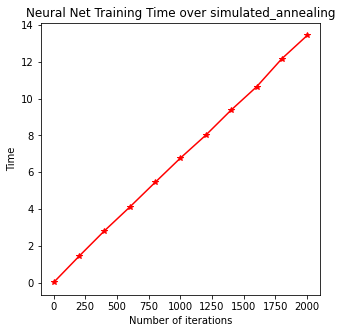

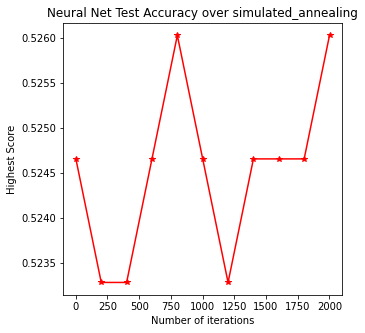

NeuralNetwork(clip_max=5, hidden_nodes=[6, 6], learning_rate=0.001,
              max_iters=2001)

In [258]:
sa_times = []
sa_acc = []
iters_range = range(1, 2200, 200)
measure_nn(sa_times, sa_acc, iters_range, "simulated_annealing")

Genetic Algorithm

In [259]:
ga_times = []
ga_acc = []
nnga = nn_random_opt(algorithm = 'genetic_alg', train_x = trainx, train_y=trainy, test_x=testx, test_y=testy, activation = 'tanh', accuracies=hc_acc, times = hc_times, max_iters=100, summarize=True)

              precision    recall  f1-score   support

           0       0.55      0.78      0.64       357
           1       0.65      0.40      0.49       373

    accuracy                           0.58       730
   macro avg       0.60      0.59      0.57       730
weighted avg       0.60      0.58      0.57       730

[[277  80]
 [225 148]]
genetic_alg test accuracy: 0.5821917808219178
genetic_alg time elapsed: 75.02814364433289


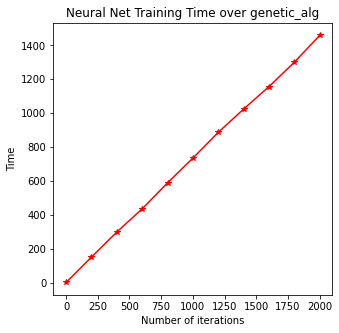

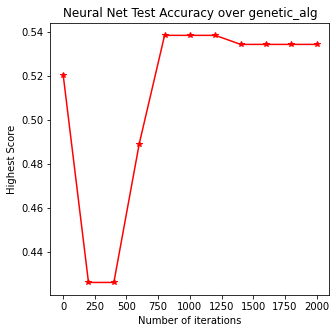

NeuralNetwork(clip_max=5, hidden_nodes=[6, 6], learning_rate=0.001,
              max_iters=2001)

In [260]:
#### Warning: This takes roughly 2 hours to run ####
ga_times = []
ga_acc = []
iters_range = range(1, 2200, 200)
measure_nn(ga_times, ga_acc, iters_range, "genetic_alg")

Gradient Descent

In [261]:
gd_times = []
gd_acc = []
nngd = nn_random_opt(algorithm = 'gradient_descent', train_x = trainx, train_y=trainy, test_x=testx, test_y=testy, activation = 'tanh', accuracies=hc_acc, times = hc_times, max_iters=10000, summarize=True)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       357
           1       0.80      0.76      0.78       373

    accuracy                           0.78       730
   macro avg       0.78      0.78      0.78       730
weighted avg       0.78      0.78      0.78       730

[[288  69]
 [ 90 283]]
gradient_descent test accuracy: 0.7821917808219178
gradient_descent time elapsed: 85.3963418006897


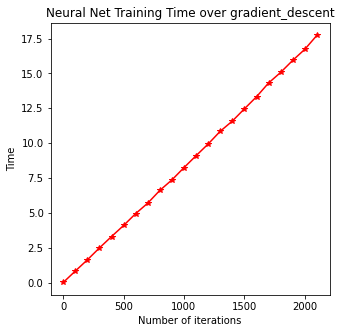

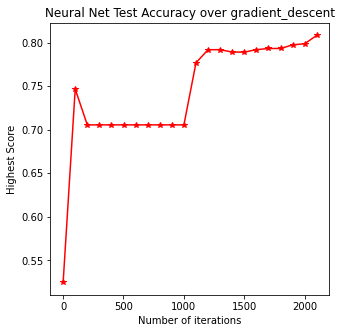

NeuralNetwork(clip_max=5, hidden_nodes=[6, 6], learning_rate=0.001,
              max_iters=2101)

In [262]:
gd_times = []
gd_acc = []
iters_range = range(1, 2200, 100)
measure_nn(gd_times, gd_acc, iters_range, "gradient_descent")

Next, test RHC, GA, SA, and MIMIC on three known optimization problems using mlrose

In [263]:
def train_and_time(algo, times, scores):
    start = time.time()
    state, top_score = algo()
    end = time.time()
    times.append(end - start)
    scores.append(top_score)

Problem 1: 
Traveling Sales Person

In [264]:
hill_times = []
hill_scores = []
anneal_times = []
anneal_scores = []
genetic_times = []
genetic_scores = []
mimic_times = []
mimic_scores = []

def tsp(points):
    dist = []
    for x in range(num_points):
        for y in range(num_points):
            if x!=y:
                random.seed(x+y)
                dist_list.append((x, y, random.uniform(0.0, 1.0)))
    fitness_dists = mlrose.TravellingSales(distances=dist_list)
    tsp_problem = mlrose.TSPOpt(length=num_points, fitness_fn=fitness_dists, maximize=True)

    print ("Traveling Salesman Problem with ", num_points, " points")

    train_and_time(lambda : mlrose.random_hill_climb(problem=tsp_problem, max_attempts=1),hill_times, hill_scores)
    train_and_time(lambda : mlrose.simulated_annealing(problem=tsp_problem, max_attempts=1), anneal_times, anneal_scores)
    train_and_time(lambda : mlrose.genetic_alg(pop_size = 30, problem=tsp_problem, max_attempts=1), genetic_times, genetic_scores)
    train_and_time(lambda : mlrose.mimic(pop_size = 30, problem=tsp_problem, max_attempts=1), mimic_times, mimic_scores)
    
    

Traveling Salesman Problem with  10  points
Traveling Salesman Problem with  10  points
Traveling Salesman Problem with  10  points
Traveling Salesman Problem with  10  points


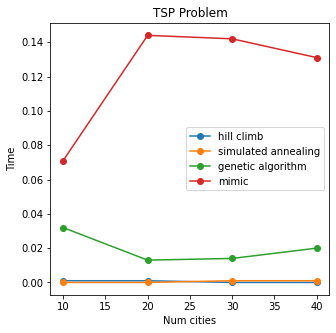

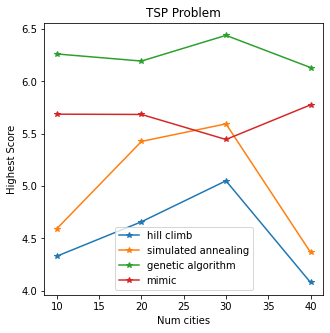

In [265]:
point_range = range(10,50,10)
for p in point_range:
    tsp(p)
plt.rcParams["figure.figsize"] = (5,5)

plt.plot(point_range,hill_times,'o-',point_range,anneal_times,'o-',point_range,genetic_times,'o-',point_range,mimic_times,'o-')
plt.title("TSP Problem")
plt.xlabel("Num cities")
plt.ylabel("Time")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()

plt.plot(point_range,hill_scores,'*-',point_range,anneal_scores,'*-', point_range,genetic_scores,'*-',point_range,mimic_scores,'*-')
plt.title("TSP Problem")
plt.xlabel("Num cities")
plt.ylabel("Highest Score")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()

In [266]:
sp_hill_times = []
sp_hill_scores = []
sp_anneal_times = []
sp_anneal_scores = []
sp_genetic_times = []
sp_genetic_scores = []
sp_mimic_times = []
sp_mimic_scores = []

def run_six_peaks(num_points):
    six_peaks = mlrose.DiscreteOpt(length = num_points,fitness_fn = mlrose.SixPeaks(t_pct=0.15))
    print ("Six Peaks Problem with ", num_points, " points")
    train_and_time(lambda : mlrose.random_hill_climb(problem=six_peaks, max_attempts=6),sp_hill_times, sp_hill_scores)
    train_and_time(lambda : mlrose.simulated_annealing(problem=six_peaks, max_attempts=6), sp_anneal_times, sp_anneal_scores)
    train_and_time(lambda : mlrose.genetic_alg(pop_size = 30, problem=six_peaks, max_attempts=6), sp_genetic_times, sp_genetic_scores)
    train_and_time(lambda : mlrose.mimic(pop_size = 30, problem=six_peaks, max_attempts=6), sp_mimic_times, sp_mimic_scores)

Six Peaks Problem with  10  points
Six Peaks Problem with  20  points
Six Peaks Problem with  30  points
Six Peaks Problem with  40  points
Six Peaks Problem with  50  points
Six Peaks Problem with  60  points


C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\mlrose\algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


Six Peaks Problem with  70  points


C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\mlrose\algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


Six Peaks Problem with  80  points


C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\mlrose\algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


Six Peaks Problem with  90  points


C:\Users\magamp\AppData\Roaming\Python\Python38\site-packages\mlrose\algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


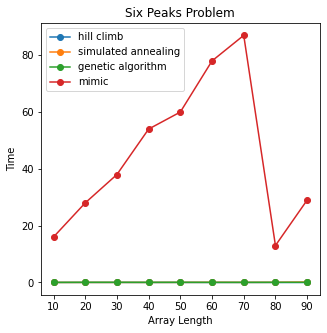

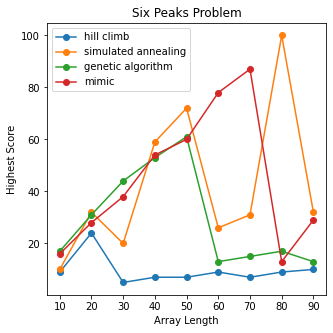

In [267]:
point_range = range(10,100,10)
for p in point_range:
    run_six_peaks(p)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(point_range,cp_hill_times,'o-',point_range,cp_anneal_times,'o-',point_range,cp_genetic_times,'o-',point_range,cp_mimic_scores,'o-')
plt.title("Six Peaks Problem")
plt.xlabel("Array Length")
plt.ylabel("Time")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()

plt.plot(point_range,cp_hill_scores,'o-',point_range,cp_anneal_scores,'o-', point_range,cp_genetic_scores,'o-',point_range,cp_mimic_scores,'o-')
plt.title("Six Peaks Problem")
plt.xlabel("Array Length")
plt.ylabel("Highest Score")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()

In [268]:
ff_hill_times = []
ff_hill_scores = []
ff_anneal_times = []
ff_anneal_scores = []
ff_genetic_times = []
ff_genetic_scores = []
ff_mimic_times = []
ff_mimic_scores = []

def flip_flop(num_points):
    state =[]
    for i in range(num_points):
        state.append(random.randint(0,1))
        
    flipflop = mlrose.DiscreteOpt(length = num_points,fitness_fn = mlrose.FlipFlop())
    print ("Flip Flop Problem with ", num_points, " points")
    train_and_time(lambda : mlrose.random_hill_climb(problem=flipflop, max_attempts=6),ff_hill_times, ff_hill_scores)
    train_and_time(lambda : mlrose.simulated_annealing(problem=flipflop, max_attempts=6), ff_anneal_times, ff_anneal_scores)
    train_and_time(lambda : mlrose.genetic_alg(pop_size = 30, problem=flipflop, max_attempts=6), ff_genetic_times, ff_genetic_scores)
    train_and_time(lambda : mlrose.mimic(pop_size = 30, problem=flipflop, max_attempts=6), ff_mimic_times, ff_mimic_scores)

Flip Flop Problem with  10  points
Flip Flop Problem with  30  points
Flip Flop Problem with  50  points
Flip Flop Problem with  70  points
Flip Flop Problem with  90  points


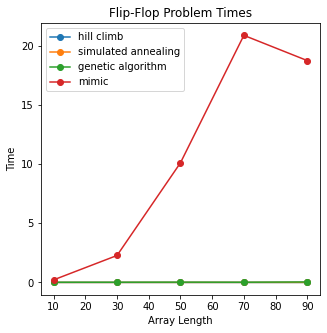

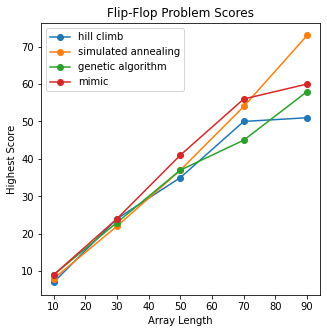

In [269]:
point_range = range(10,100,20)
for p in point_range:
    flip_flop(num_points = p)
plt.rcParams["figure.figsize"] = (5,5)

plt.plot(point_range,ff_hill_times,'o-',point_range,ff_anneal_times,'o-',point_range,ff_genetic_times,'o-',point_range,ff_mimic_times,'o-')
plt.title("Flip-Flop Problem Times")
plt.xlabel("Array Length")
plt.ylabel("Time")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()

plt.plot(point_range,ff_hill_scores,'o-',point_range,ff_anneal_scores,'o-', point_range,ff_genetic_scores,'o-',point_range,ff_mimic_scores,'o-')
plt.title("Flip-Flop Problem Scores")
plt.xlabel("Array Length")
plt.ylabel("Highest Score")
plt.legend(["hill climb", "simulated annealing","genetic algorithm","mimic"])
plt.show()